Import Libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import os



Download NLTK Resources

In [61]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bshanmugam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [62]:

file_path = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")

df[['reviews.text', 'reviews.rating']].dropna()
df[df['reviews.text'].str.strip() != '']
df[df['reviews.title'].str.strip() != '']
df['full_review'] = df['reviews.title'].fillna('') + ' - ' + df['reviews.text'].fillna('')
df.rename(columns={'reviews.text': 'text', 'reviews.rating': 'rating','reviews.doRecommend' : 'doRecommend'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)

# After first columns exploration here are the columns we will drop as they do not provide useful information for future activities
columntodrop = ["id","dateAdded","dateUpdated","keys","manufacturer","manufacturerNumber","reviews.date","reviews.dateAdded","reviews.dateSeen","reviews.id","reviews.numHelpful","reviews.sourceURLs","reviews.text","reviews.title","reviews.username"]
df.drop(columns=columntodrop, inplace=True, errors='ignore')
print(f"After removing columns: {df.shape}")

##Remove DUplicates 
print(f"Number of duplicate reviews: {df.duplicated(subset=['text']).sum()}")
df = df.drop_duplicates(subset=['text'])
print(f"Shape after dropping duplicates: {df.shape}")
df.columns

Original shape: (5000, 24)
After removing missing: (5000, 25)
After removing columns: (5000, 11)
Number of duplicate reviews: 615
Shape after dropping duplicates: (4385, 11)


Index(['name', 'asins', 'brand', 'categories', 'primaryCategories',
       'imageURLs', 'doRecommend', 'rating', 'text', 'sourceURLs',
       'full_review'],
      dtype='object')

Visualize Ratings Distribution

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_4117/2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


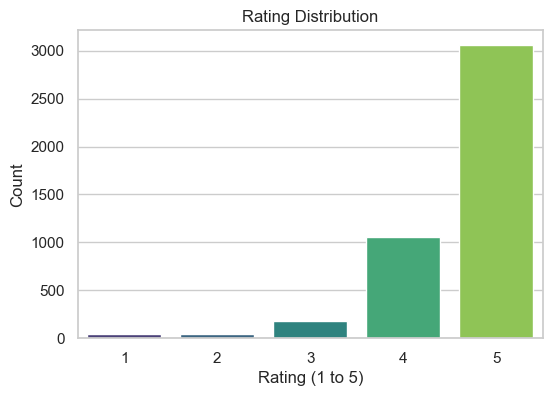

In [63]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_4117/759677541.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


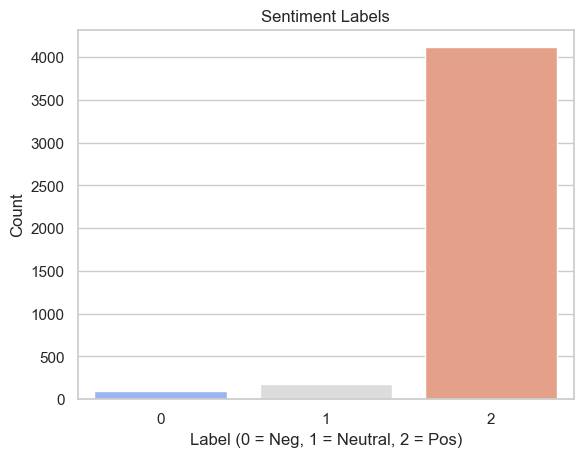

In [64]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()

Clean Text (Simple + Stopwords + Stemming)

In [71]:
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)
   


df['clean_text'] = df['full_review'].apply(simple_clean_text)
df[['full_review', 'clean_text']].sample(10)


,full_review,clean_text
1301,Great addition to my home - I didn‚Äôt know wh...,great addition to my home i didnt know what i ...
3525,"Kindle 8"" - Gift for daughter. She loves it. J...",kindle gift for daughter she love it just open...
1024,Great product - I have had the competitive pro...,great product i have had the competitive produ...
1044,Incredible - A wonderful use of creativity and...,incredible a wonderful use of creativity and d...
2617,good - everything was as I expected.... and or...,good everything wa a i expected and order it o...
125,FREAKIN' AWESOME - Amazon - Echo Show is the b...,freakin awesome amazon echo show is the best o...
1173,Echo My Echo - One For Us One For The Kids For...,echo my echo one for u one for the kid for chr...
4899,Excellent for Amazon product users and shopper...,excellent for amazon product user and shopper ...
1873,Great for kids. - I got this for my two grands...,great for kid i got this for my two grandson a...
3578,great product - Nice upgrade from my old kindl...,great product nice upgrade from my old kindle ...


Top Common Words per Sentiment Class

In [66]:
from collections import Counter
import pandas as pd

def get_top_n_words(text_series, n=15):
    # Ensure we are dealing with strings
    all_words = ' '.join(text_series.dropna().astype(str)).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

# Loop through each sentiment label and show top words
for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'], n=15)
    print(top_words)



🔹 Top words for Negative reviews:
    word  count
0    the    191
1      i    172
2     it    147
3     to    134
4    and    108
5      a    101
6    not     97
7    for     77
8     is     76
9   this     69
10    my     51
11    wa     46
12  that     42
13    of     41
14    on     38

🔹 Top words for Neutral reviews:
      word  count
0      the    311
1       it    276
2        a    231
3       to    212
4        i    191
5      for    171
6      and    153
7       is    119
8      not    109
9      but     98
10  tablet     94
11    this     85
12    good     76
13      my     74
14      of     71

🔹 Top words for Positive reviews:
      word  count
0      the   5769
1       it   4736
2      and   4292
3       to   4233
4      for   3895
5        a   3792
6        i   3714
7    great   2847
8       my   2585
9       is   2536
10    this   2181
11  tablet   1862
12    love   1803
13      of   1332
14    with   1325


Word Cloud per Sentiment Class

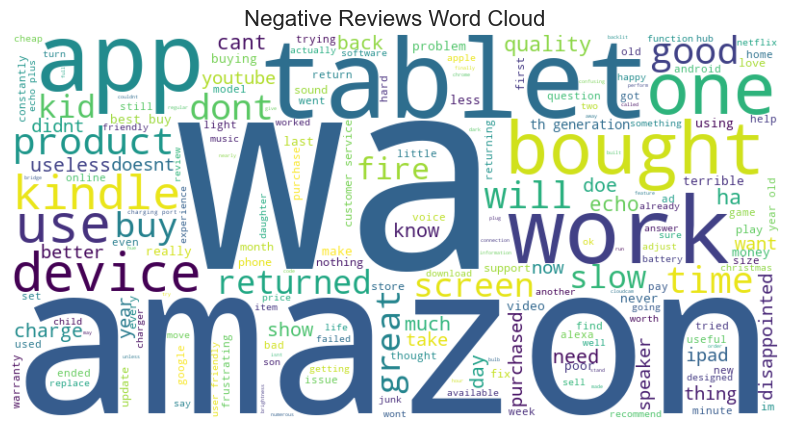

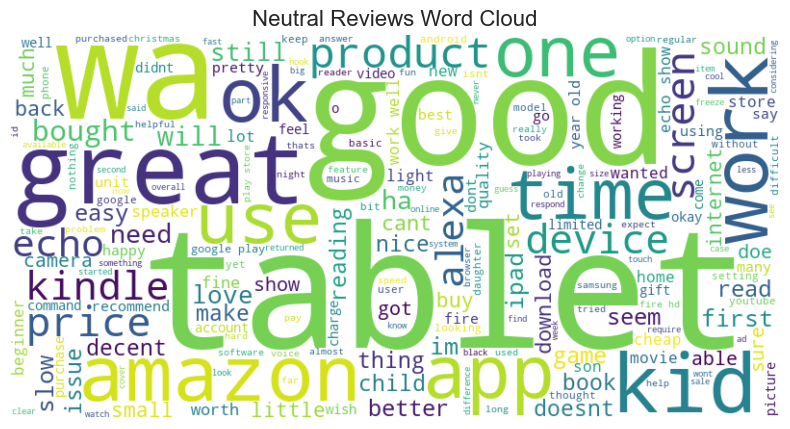

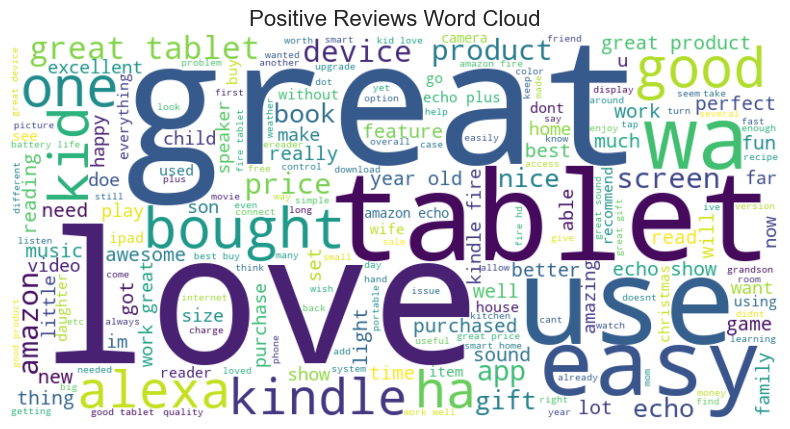

In [67]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [68]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")

✅ Saved: data/cleaned_amazon_reviews_final.csv
